In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
from itertools import product
%matplotlib inline

In [2]:
sns.set_style('dark')
sns.set(font_scale=1.3)
# need to run this twice...
sns.set_style('dark')
sns.set(font_scale=1.3)

In [3]:
# Here is the raw data
stanford_known_positives = 37
stanford_known_negatives = 30

stanford_tested_positives = 25
stanford_tested_negatives = 30


manufacturer_known_positives_igg = 75
manufacturer_known_positives_igm = 85
manufacturer_known_positives = 75+85
manufacturer_known_negatives = 371

manufacturer_tested_positives_igg = 75
manufacturer_tested_positives_igm = 78
manufacturer_tested_positives = 75+78
manufacturer_tested_negatives = 369

manufacturer_tested_positives_cons = 78
manufacturer_known_positives_cons = 85

In [27]:
def get_data(scenario):
    '''
    Grab the data corresponding to scenario 1, 2, or 3 as described in the paper
    '''
    if scenario == 1:
        tested_pos = manufacturer_tested_positives_cons
        known_pos = manufacturer_known_positives_cons
        r_hat = tested_pos / known_pos

        tested_neg = manufacturer_tested_negatives
        known_neg = manufacturer_known_negatives
        s_hat = tested_neg / known_neg

    elif scenario == 2:
        tested_pos = stanford_tested_positives
        known_pos = stanford_known_positives
        r_hat = tested_pos / known_pos

        tested_neg = stanford_tested_negatives
        known_neg = stanford_known_negatives
        s_hat = tested_neg / known_neg

    elif scenario == 3:
        tested_pos = stanford_tested_positives + manufacturer_tested_positives_cons
        known_pos = stanford_known_positives + manufacturer_known_positives_cons
        r_hat = tested_pos / known_pos

        tested_neg = stanford_tested_negatives + manufacturer_tested_negatives
        known_neg = stanford_known_negatives + manufacturer_known_negatives
        s_hat = tested_neg / known_neg
    return tested_pos, known_pos, r_hat, tested_neg, known_neg, s_hat


In [5]:
def bootstrap_specificity(tested_neg, known_neg, n_trials=500):
    '''
    Bootstrap the specificity estimate
    '''
    test_negs = np.zeros(known_neg)
    test_negs[:tested_neg] = 1.
    specificities = []
    for b in range(n_trials):
        p = np.mean(np.random.choice(test_negs, size=known_neg))
        specificities.append(p)
    return specificities


def bootstrap_sensitivity(tested_pos, known_pos, n_trials=500):
    '''
    Bootstrap the sensitivity estimate
    '''
    test_pos = np.zeros(known_pos)
    test_pos[:tested_pos] = 1.
    sensitivities = []
    for b in range(n_trials):
        p = np.mean(np.random.choice(test_pos, size=known_pos))
        sensitivities.append(p)
    return sensitivities

Estimated Positive Rate: 1.2
95% CI: (0.124, 2.05)


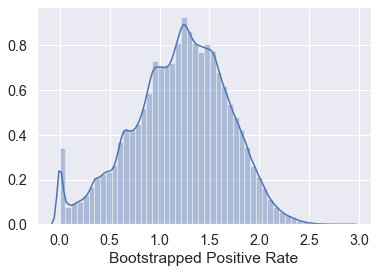

In [26]:
# Pick scenario 1, 2, or 3 and grab the corresponding data
scenario = 3
tested_pos, known_pos, r_hat, tested_neg, known_neg, s_hat = get_data(scenario)


sample_size = 3330
sample_tested_pos = 50
# Generate positive samples to bootstrap
obs = np.zeros(sample_size)
obs[:sample_tested_pos] = 1.


# Lets generate lots of bootstrap samples of the specificity and sensitivity
n_trials_spec_sens = 10000
specificities = bootstrap_specificity(tested_neg, known_neg, n_trials=n_trials_spec_sens)
sensitivities = bootstrap_sensitivity(tested_pos, known_pos, n_trials=n_trials_spec_sens)

# We will generate `n_trials` bootstrap samples of the observed positive rate
n_trials = 1000

true_rates = []
for b in range(n_trials):
    # bootstrap observed data
    b_sample = np.random.choice(obs, size = len(obs))
    # compute the corresponding `q` as specified in the paper
    q_hat = np.mean(b_sample)

    # get a random sample of the bootstrapped sensitivities and specificities
    num_random_specs_sens = 50
    sample_sens = np.random.choice(sensitivities, size=num_random_specs_sens, replace=False)
    sample_specs = np.random.choice(specificities, size=num_random_specs_sens, replace=False)
    # for all combinations of the random samples, compute the bootstrap estimate of TPR
    for r_hat, s_hat in product(sample_sens, sample_specs):
        # formula for TPR comes from page 2 of Statistical Appendix
        # https://www.medrxiv.org/content/medrxiv/suppl/2020/04/17/2020.04.14.20062463.DC1/2020.04.14.20062463-1.pdf
        # see last paragraph of page 2 for note about when q_hat + s_hat - 1 <= 0.
        num = max(q_hat + s_hat - 1, 0.)
        true_rate = num / (r_hat + s_hat - 1)
        true_rates.append(true_rate)
true_rates = np.asarray(true_rates)*100

# Plot the results and compute the confidence interval
fig, ax = plt.subplots()
sns.distplot(np.asarray(true_rates), ax=ax, hist=True)
ax.set(xlabel="Bootstrapped Positive Rate")
print(f"Estimated Positive Rate: {np.mean(true_rates):.3}")
lower, upper = np.quantile(true_rates, [0.025, 0.975])
print(f"95% CI: ({lower:.3}, {upper:.3})")